In [1]:
!pip install tensorflow-gpu==2.7.0 opencv-python tensorflow_datasets matplotlib pycocotools absl-py pydot

     |██▋                             | 39.2 MB 4.2 MB/s eta 0:01:47^C

ERROR: Operation cancelled by user


In [1]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import cv2
import os
import tensorflow_datasets as tfds
import datetime
from coco import COCO
from coco_final_labels import labels as coco_labels
import shutil
from tensorflow.keras.utils import to_categorical
import matplotlib as plt
from tensorflow import keras
import random
from coco_final_labels_transfer import labels as coco_labels_transfer

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

2022-08-06 00:29:37.362082: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-06 00:29:37.377830: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-06 00:29:37.377970: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
BATCH_SIZE = 32
FROM_LOGITS = False
LEARNING_RATE = 0.001
INFO = "-"
TRAIN_IMAGES = 'data/coco_onehot_train'
VAL_IMAGES = 'data/coco_onehot_val'
TRANSFER_TRAIN = 'data/transfer_train'
TRANSFER_VAL = 'data/transfer_val'

CONFIG_STRING = "batch_size: {0} | last_dense: {1} | softmax: {2} | from_logits: {3} | lr: {4} | info: {5}"

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

2022-08-06 00:29:41.391685: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-06 00:29:41.392526: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-06 00:29:41.392714: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-06 00:29:41.392855: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 80)                163920    
                                                                 
Total params: 23,728,720
Trainable params: 23,683,280
Non-trainable params: 45,440
_________________________________________________________________


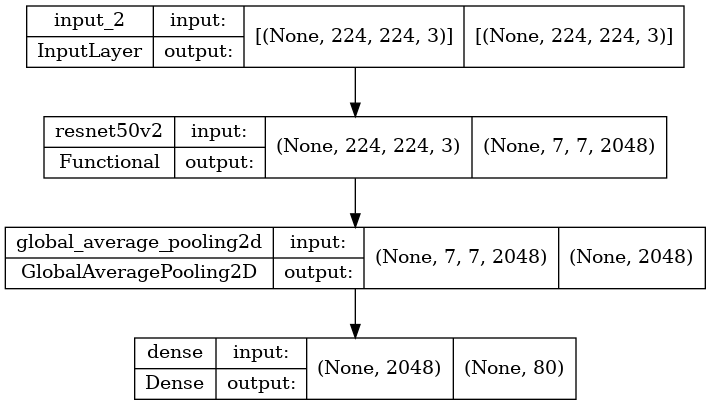

In [4]:

opt = Adam(learning_rate=LEARNING_RATE)
resnet50 = tf.keras.applications.ResNet50V2(weights='imagenet', include_top=False, input_shape = (224,224,3))

input = Input(shape=(224,224,3))
encoder = resnet50(input)
avg_pool = GlobalAveragePooling2D()(encoder)
fc = Dense(len(coco_labels), activation="softmax")(avg_pool)
model = Model(input, fc)
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=FROM_LOGITS), optimizer=opt, metrics=METRICS)

model.summary()
tf.keras.utils.plot_model(model, to_file="logs/resnet50/model.png", show_shapes=True, expand_nested=False)

18
['3339' '0' '103' '34' '224' '0' '890' '2146' '584' '145' '49383' '1930'
 '28' '1635' '372' '2437' '48' '3085' '2529' '283' '821' '197' '2035'
 '1388' '632' '2400' '110' '0' '18' '1107' '2871' '642' '510' '519' '1976'
 '421' '1579' '1216' '0' '1533' '1577' '1522' '1911' '363' '969' '438'
 '1143' '3141' '8645' '0' '104' '1713' '52' '1121' '2547' '93' '0' '0'
 '2931' '418' '220' '755' '0' '361' '959' '2063' '2331' '287' '723' '174'
 '3411' '1407' '655' '263' '1867' '662' '1955' '1037' '1810' '822' '796'
 '0' '69' '1857' '0' '3385' '0' '1066' '313' '1411' '2816']


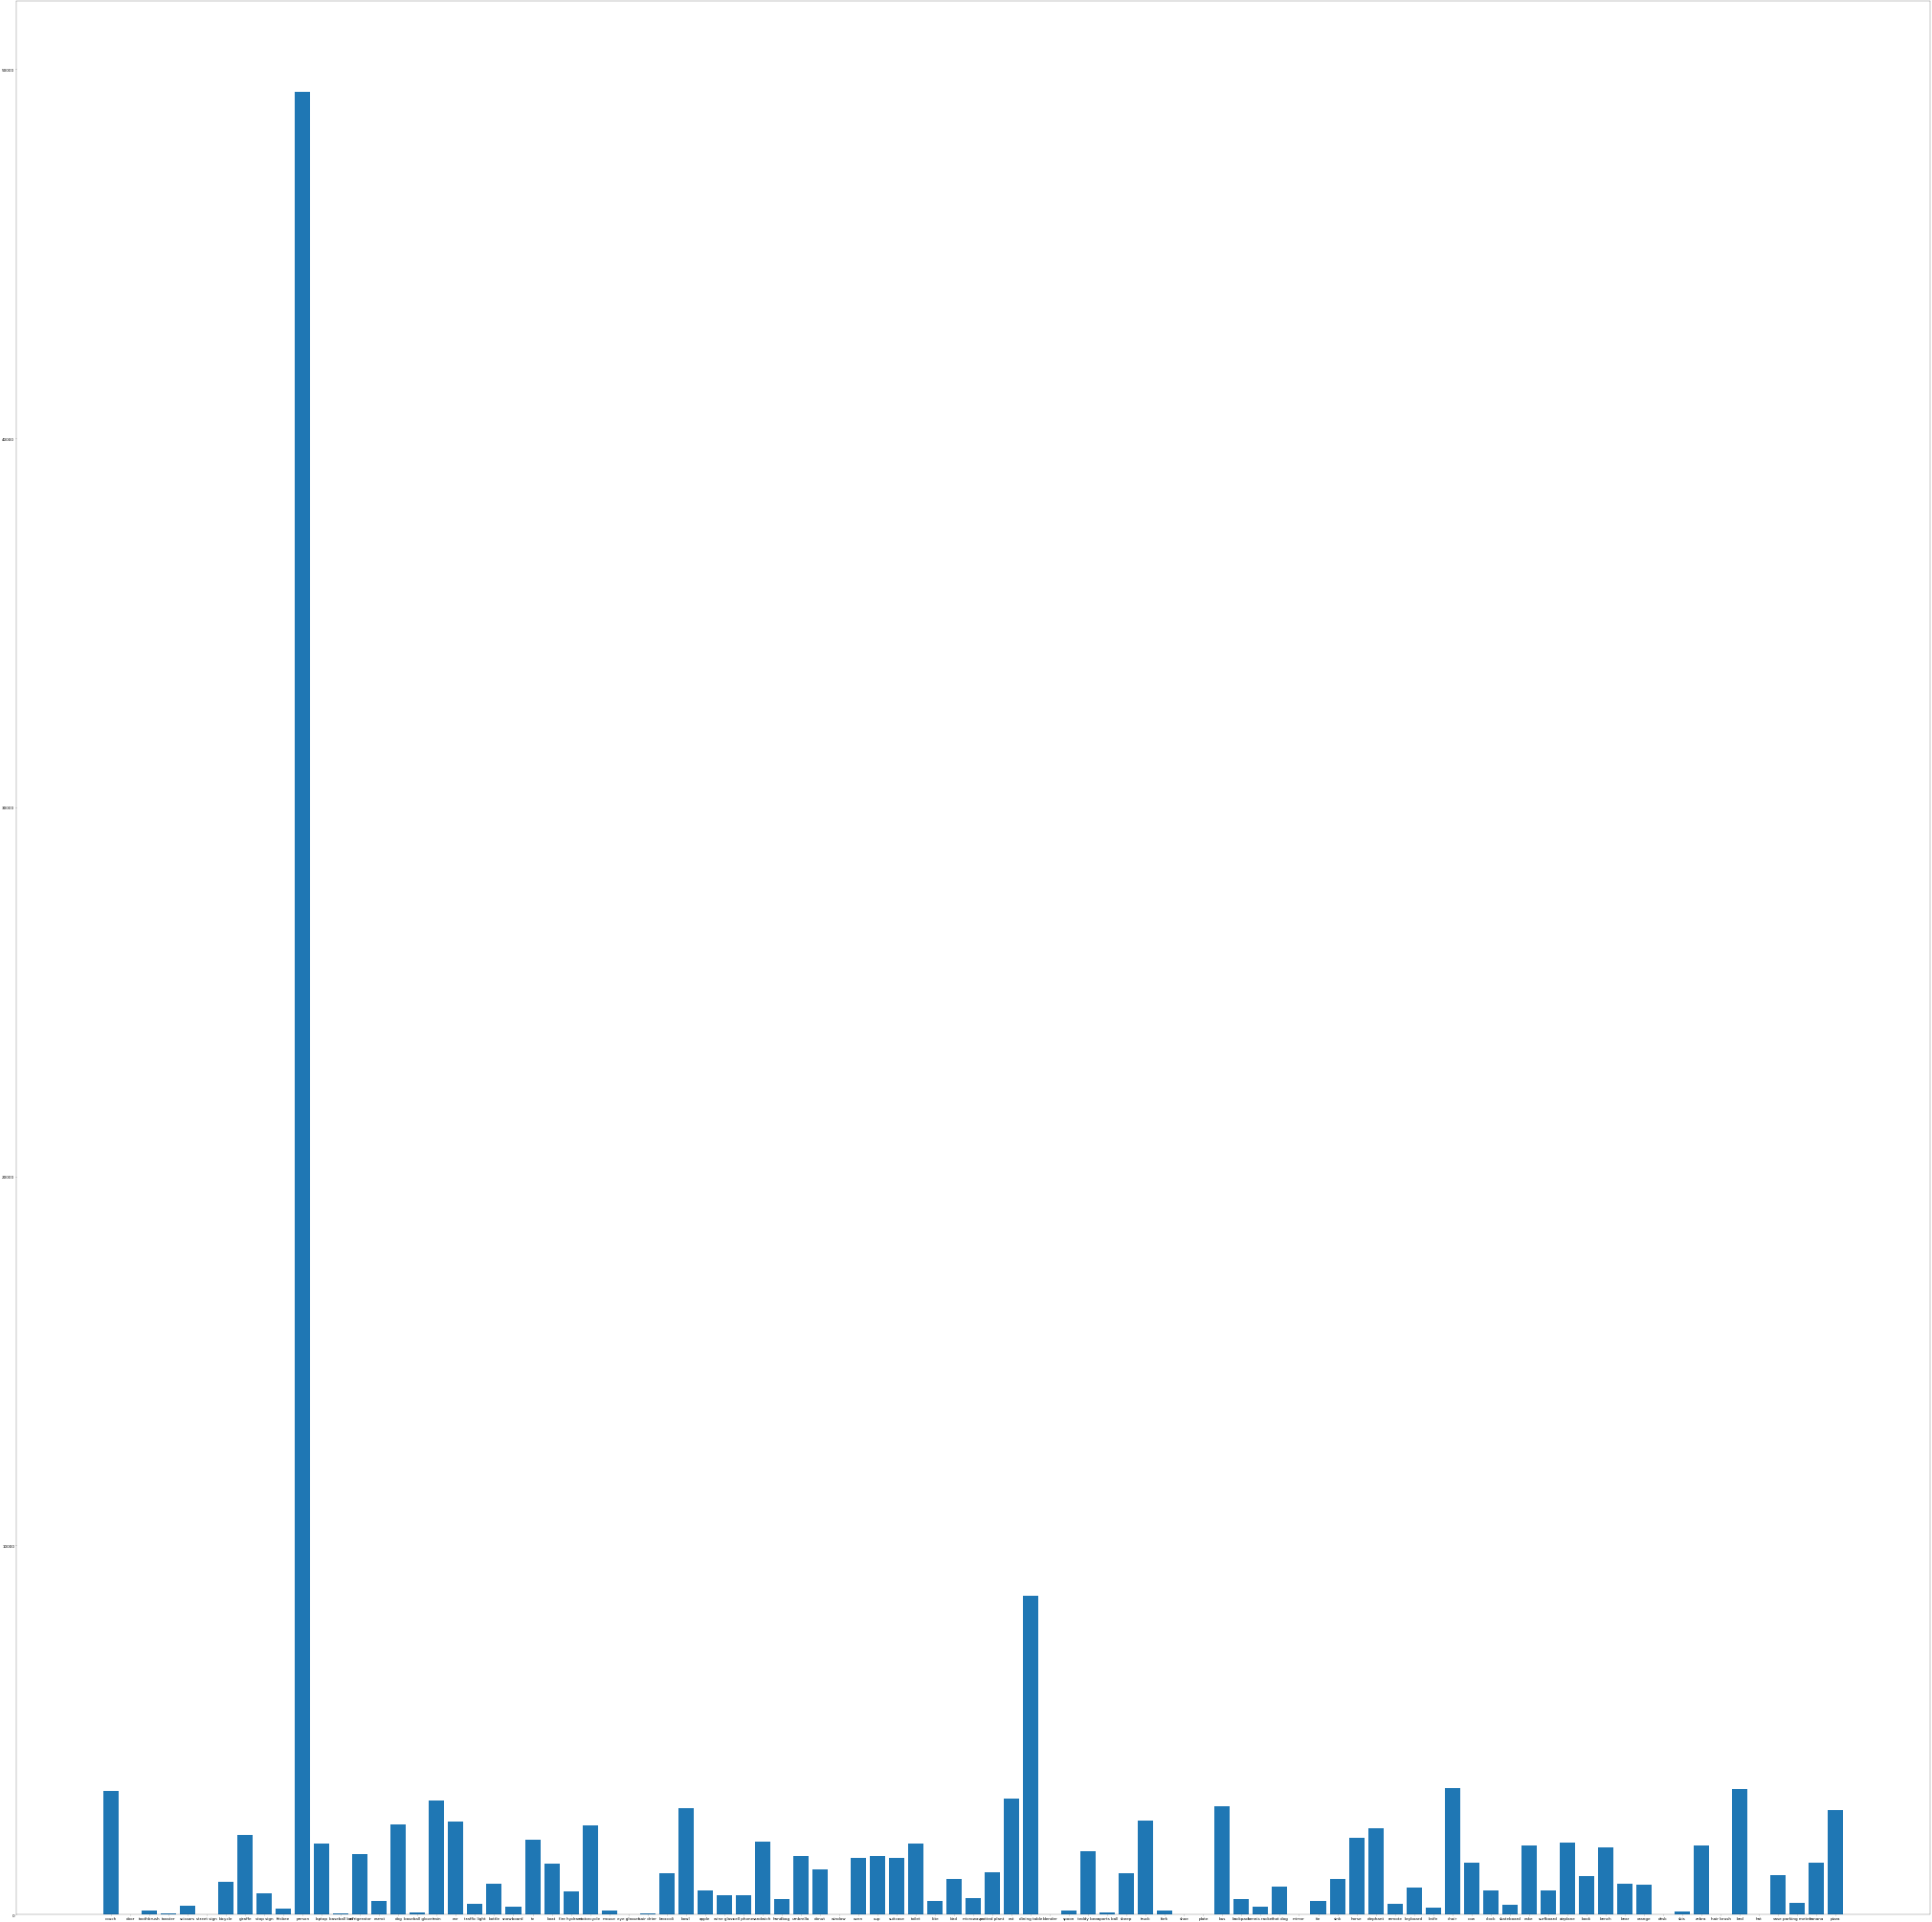

In [5]:
amounts = []
for c in os.listdir("data/coco_onehot_train"):
    amounts.append((c, len(os.listdir("data/coco_onehot_train/{0}".format(c)))))

amounts = np.array(amounts)
plt.rcParams.update({'font.size': 15})
fig = plt.pyplot.figure(figsize=(100,100), dpi=20)
ax = fig.add_axes([0,0,1,1])
ax.bar(amounts[:,0], np.asarray(amounts[:,1],dtype=int))

print(min({x for x in np.asarray(amounts[:,1],dtype=int) if x > 0}))
print(amounts[:,1])

In [6]:
train_files = {}
for d in os.listdir(TRAIN_IMAGES):
    files = os.listdir(f"{TRAIN_IMAGES}/{d}")
    if len(files) > 0:
        train_files[d] = files

print(len(train_files))

val_files = {}
for d in os.listdir(VAL_IMAGES):
    files = os.listdir(f"{VAL_IMAGES}/{d}")
    if len(files) > 0:
        val_files[d] = files
    else:
        if d in coco_labels:
            print(d)

print(len(val_files))

transfer_train_files = {}
for d in os.listdir(f"{TRANSFER_TRAIN}"):
    files = os.listdir(f"{TRANSFER_TRAIN}/{d}")
    transfer_train_files[d] = files

transfer_val_files = {}
for d in os.listdir(f"{TRANSFER_VAL}/"):
    files = os.listdir(f"{TRANSFER_VAL}/{d}")
    transfer_val_files[d] = files

print(len(transfer_train_files))
print(len(transfer_val_files))

80
80
6
6


In [7]:
def load_images(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224,224))
    img = img/255.0
    return img

def augment(image):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
    image = tf.image.adjust_saturation(image, (tf.random.uniform(()))*1.25)
    image = tf.image.adjust_brightness(image, (tf.random.uniform(()))*0.1-0.05)
    #image = tf.image.rot90(image, k=int(tf.random.uniform(())*4))
    return image


def preprocess_train(anchor, label):
    img = load_images(anchor)
    img = augment(img)
    return (img, label)

def preprocess_validation(anchor,label):
    img = load_images(anchor)
    return (img, label)

def get_training_data(labels, epoch_size=1024, training: bool=True, transfer: bool=False):
    X = []
    Y = []

    if training: 
        available_classes = list(train_files.keys())
        for i in range(epoch_size):
            c = random.choice(available_classes)
            anchor = random.choice(train_files[c])
            X.append(f"{TRAIN_IMAGES}/{c}/{anchor}")
            index = labels.index(c)
            lbl = np.zeros(len(labels))
            lbl[index] = 1
            Y.append(lbl)

    if transfer:
        available_classes = list(transfer_train_files.keys())
        for i in range(max(1,int(epoch_size/80))):
            c = random.choice(available_classes)
            anchor = random.choice(transfer_train_files[c])
            X.append(f"{TRANSFER_TRAIN}/{c}/{anchor}")
            index = labels.index(c)
            lbl = np.zeros(len(labels))
            lbl[index] = 1
            Y.append(lbl)

    return (X, Y)

def get_training_dataset(labels, epoch_size=1024, training: bool=True, transfer: bool=False):
    data = get_training_data(labels, epoch_size, training, transfer)
    x = tf.data.Dataset.from_tensor_slices(data[0])
    y = tf.data.Dataset.from_tensor_slices(data[1])
    final_data = tf.data.Dataset.zip((x,y))
    processed_data = final_data.map(preprocess_train)
    return processed_data

In [47]:
print(train_files.keys())

dict_keys(['couch', 'toothbrush', 'toaster', 'scissors', 'bicycle', 'giraffe', 'stop sign', 'frisbee', 'person', 'laptop', 'baseball bat', 'refrigerator', 'carrot', 'dog', 'baseball glove', 'train', 'car', 'traffic light', 'bottle', 'snowboard', 'tv', 'boat', 'fire hydrant', 'motorcycle', 'mouse', 'hair drier', 'broccoli', 'bowl', 'apple', 'wine glass', 'cell phone', 'sandwich', 'handbag', 'umbrella', 'donut', 'oven', 'cup', 'suitcase', 'toilet', 'kite', 'bird', 'microwave', 'potted plant', 'cat', 'dining table', 'spoon', 'teddy bear', 'sports ball', 'sheep', 'truck', 'fork', 'bus', 'backpack', 'tennis racket', 'hot dog', 'tie', 'sink', 'horse', 'elephant', 'remote', 'keyboard', 'knife', 'chair', 'cow', 'clock', 'skateboard', 'cake', 'surfboard', 'airplane', 'book', 'bench', 'bear', 'orange', 'skis', 'zebra', 'bed', 'vase', 'parking meter', 'banana', 'pizza'])


In [8]:
def get_validation_data(labels, initial: bool=True, transfer: bool=False):
    X = []
    Y = []
    if initial:
        dir = VAL_IMAGES
        for root, dirs, files in os.walk(dir):
            for name in files:
                image = os.path.join(root, name)
                index = labels.index(image.split('/')[-2])
                lbl = np.zeros(len(labels))
                lbl[index] = 1
                X.append(image)
                Y.append(lbl)

    if transfer:
        dir = TRANSFER_VAL
        for root, dirs, files in os.walk(dir):
            for name in files:
                image = os.path.join(root, name)
                index = labels.index(image.split('/')[-2])
                lbl = np.zeros(len(labels))
                lbl[index] = 1
                X.append(image)
                Y.append(lbl)

    x = tf.data.Dataset.from_tensor_slices(X)
    y = tf.data.Dataset.from_tensor_slices(Y)
    final_data = tf.data.Dataset.zip((x,y))
    processed_data = final_data.map(preprocess_validation)
    return processed_data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


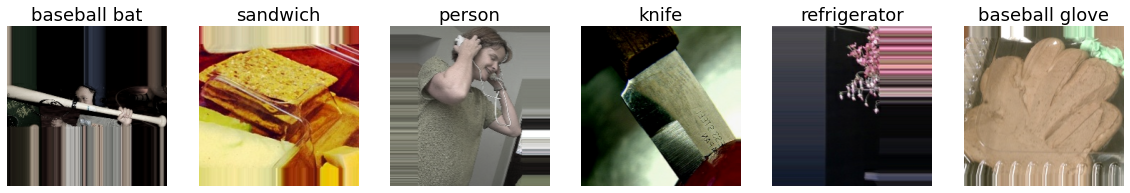

In [9]:
dataset = get_training_dataset(coco_labels, 6, True)
dataset = dataset.as_numpy_iterator()

plt.pyplot.figure(figsize=(20,20))
for i in range(6):
    ax = plt.pyplot.subplot(1,6,i+1)
    datatuple = next(dataset)
    plt.pyplot.imshow(datatuple[0])
    label = datatuple[1]
    label = np.where(label == 1)[0][0]
    plt.pyplot.title(coco_labels[label])
    plt.pyplot.axis("off")

In [9]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir logs/resnet50

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = 'logs/resnet50/{0}'.format(current_time)
weight_dir = 'weights/resnet50/{0}'.format(current_time)

summary_writer = tf.summary.create_file_writer(log_dir)
summary_writer.set_as_default()
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, update_freq=100)
weight_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=weight_dir,
    save_weights_only=False,
    monitor='val_precision',
    mode='max',
    save_best_only=False)

In [10]:
val_data = get_validation_data(coco_labels)
val_data = val_data.batch(32)
val_data = val_data.prefetch(32)

train_data = get_training_dataset(coco_labels, 2**18)
train_data = train_data.batch(32)
train_data = train_data.prefetch(32)

def train():
    print("Starting training...")

    #loss = siamese_model.fit(train_data, batch_size=32, epochs=20, validation_data=val_data, callbacks=[tensorboard_callback])
    model.fit(train_data, batch_size=BATCH_SIZE, validation_data=val_data, callbacks=[tensorboard_callback, weight_callback], epochs=10)

train()

Starting training...
Epoch 1/10


2022-08-06 00:30:38.984518: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101
2022-08-06 00:30:39.687695: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-06 00:30:41.086643: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


8192/8192 [==============================] - ETA: 0s - loss: 1.2710 - tp: 141830.0000 - fp: 24101.0000 - tn: 20685272.0000 - fn: 120314.0000 - accuracy: 0.6549 - precision: 0.8548 - recall: 0.5410 - auc: 0.9743 - prc: 0.7368

2022-08-06 00:56:25.639991: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: weights/resnet50/20220806-003011/assets
8192/8192 [==============================] - 1557s 189ms/step - loss: 1.2710 - tp: 141830.0000 - fp: 24101.0000 - tn: 20685272.0000 - fn: 120314.0000 - accuracy: 0.6549 - precision: 0.8548 - recall: 0.5410 - auc: 0.9743 - prc: 0.7368 - val_loss: 1.4818 - val_tp: 8199.0000 - val_fp: 2515.0000 - val_tn: 1261880.0000 - val_fn: 7806.0000 - val_accuracy: 0.6074 - val_precision: 0.7653 - val_recall: 0.5123 - val_auc: 0.9612 - val_prc: 0.6638
Epoch 2/10
8192/8192 [==============================] - 1554s 190ms/step - loss: 0.5227 - tp: 209308.0000 - fp: 19220.0000 - tn: 20690248.0000 - fn: 52836.0000 - accuracy: 0.8473 - precision: 0.9159 - recall: 0.7984 - auc: 0.9932 - prc: 0.9241 - val_loss: 1.1507 - val_tp: 10280.0000 - val_fp: 2691.0000 - val_tn: 1261704.0000 - val_fn: 5725.0000 - val_accuracy: 0.6981 - val_precision: 0.7925 - val_recall: 0.6423 - val_auc: 0.9698 - val_prc: 0.7703
Epoch 3/10
8192/8192 [============

In [16]:
import itertools
def plot_confusion_matrix(cm, class_names, filename):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    
    Args:
       cm (array, shape = [n, n]): a confusion matrix of integer classes
       class_names (array, shape = [n]): String names of the integer classes
    """
    plt.pyplot.rcParams.update({'font.size': 10})
    figure = plt.pyplot.figure(figsize=(30, 30))
    plt.pyplot.imshow(cm, interpolation='nearest', cmap=plt.pyplot.cm.Blues)
    plt.pyplot.title("Confusion matrix")
    plt.pyplot.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.pyplot.xticks(tick_marks, class_names, rotation=90)
    plt.pyplot.yticks(tick_marks, class_names)
    
    cm = np.array(cm)
    cm = np.nan_to_num(0)
    # Normalize the confusion matrix.
    #cm = np.around(cm.astype('float') / cm.sum(axis=0)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    # threshold = cm.max() / 2.
    
    # for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    #     color = "white" if cm[i, j] > threshold else "black"
    #     plt.pyplot.text(j, i, cm[i, j], horizontalalignment="center", color=color)
        
    plt.pyplot.tight_layout()
    plt.pyplot.ylabel('True label')
    plt.pyplot.xlabel('Predicted label')
    plt.pyplot.savefig(filename)
    return figure

[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
[8, 57, 8, 8, 21, 31, 31, 40, 57, 40, 13, 8, 4, 8, 40, 8, 8, 8, 8, 8, 8, 11, 8, 8, 8, 8, 8, 57, 46, 8, 0, 8]
[[0.47151899 0.         0.         ... 0.         0.00719424 0.        ]
 [0.         0.23529412 0.         ... 0.         0.         0.        ]
 [0.         0.         0.33333333 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.85185185 0.         0.        ]
 [0.         0.         0.         ... 0.         0.69064748 0.        ]
 [0.         0.         0.         ... 0.         0.         0.79133858]]


/tmp/ipykernel_4976/2454644673.py:21: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cm = cm / cm.astype(np.float).sum(axis=0)
/tmp/ipykernel_4976/2454644673.py:21: RuntimeWarning: invalid value encountered in true_divide
  cm = cm / cm.astype(np.float).sum(axis=0)


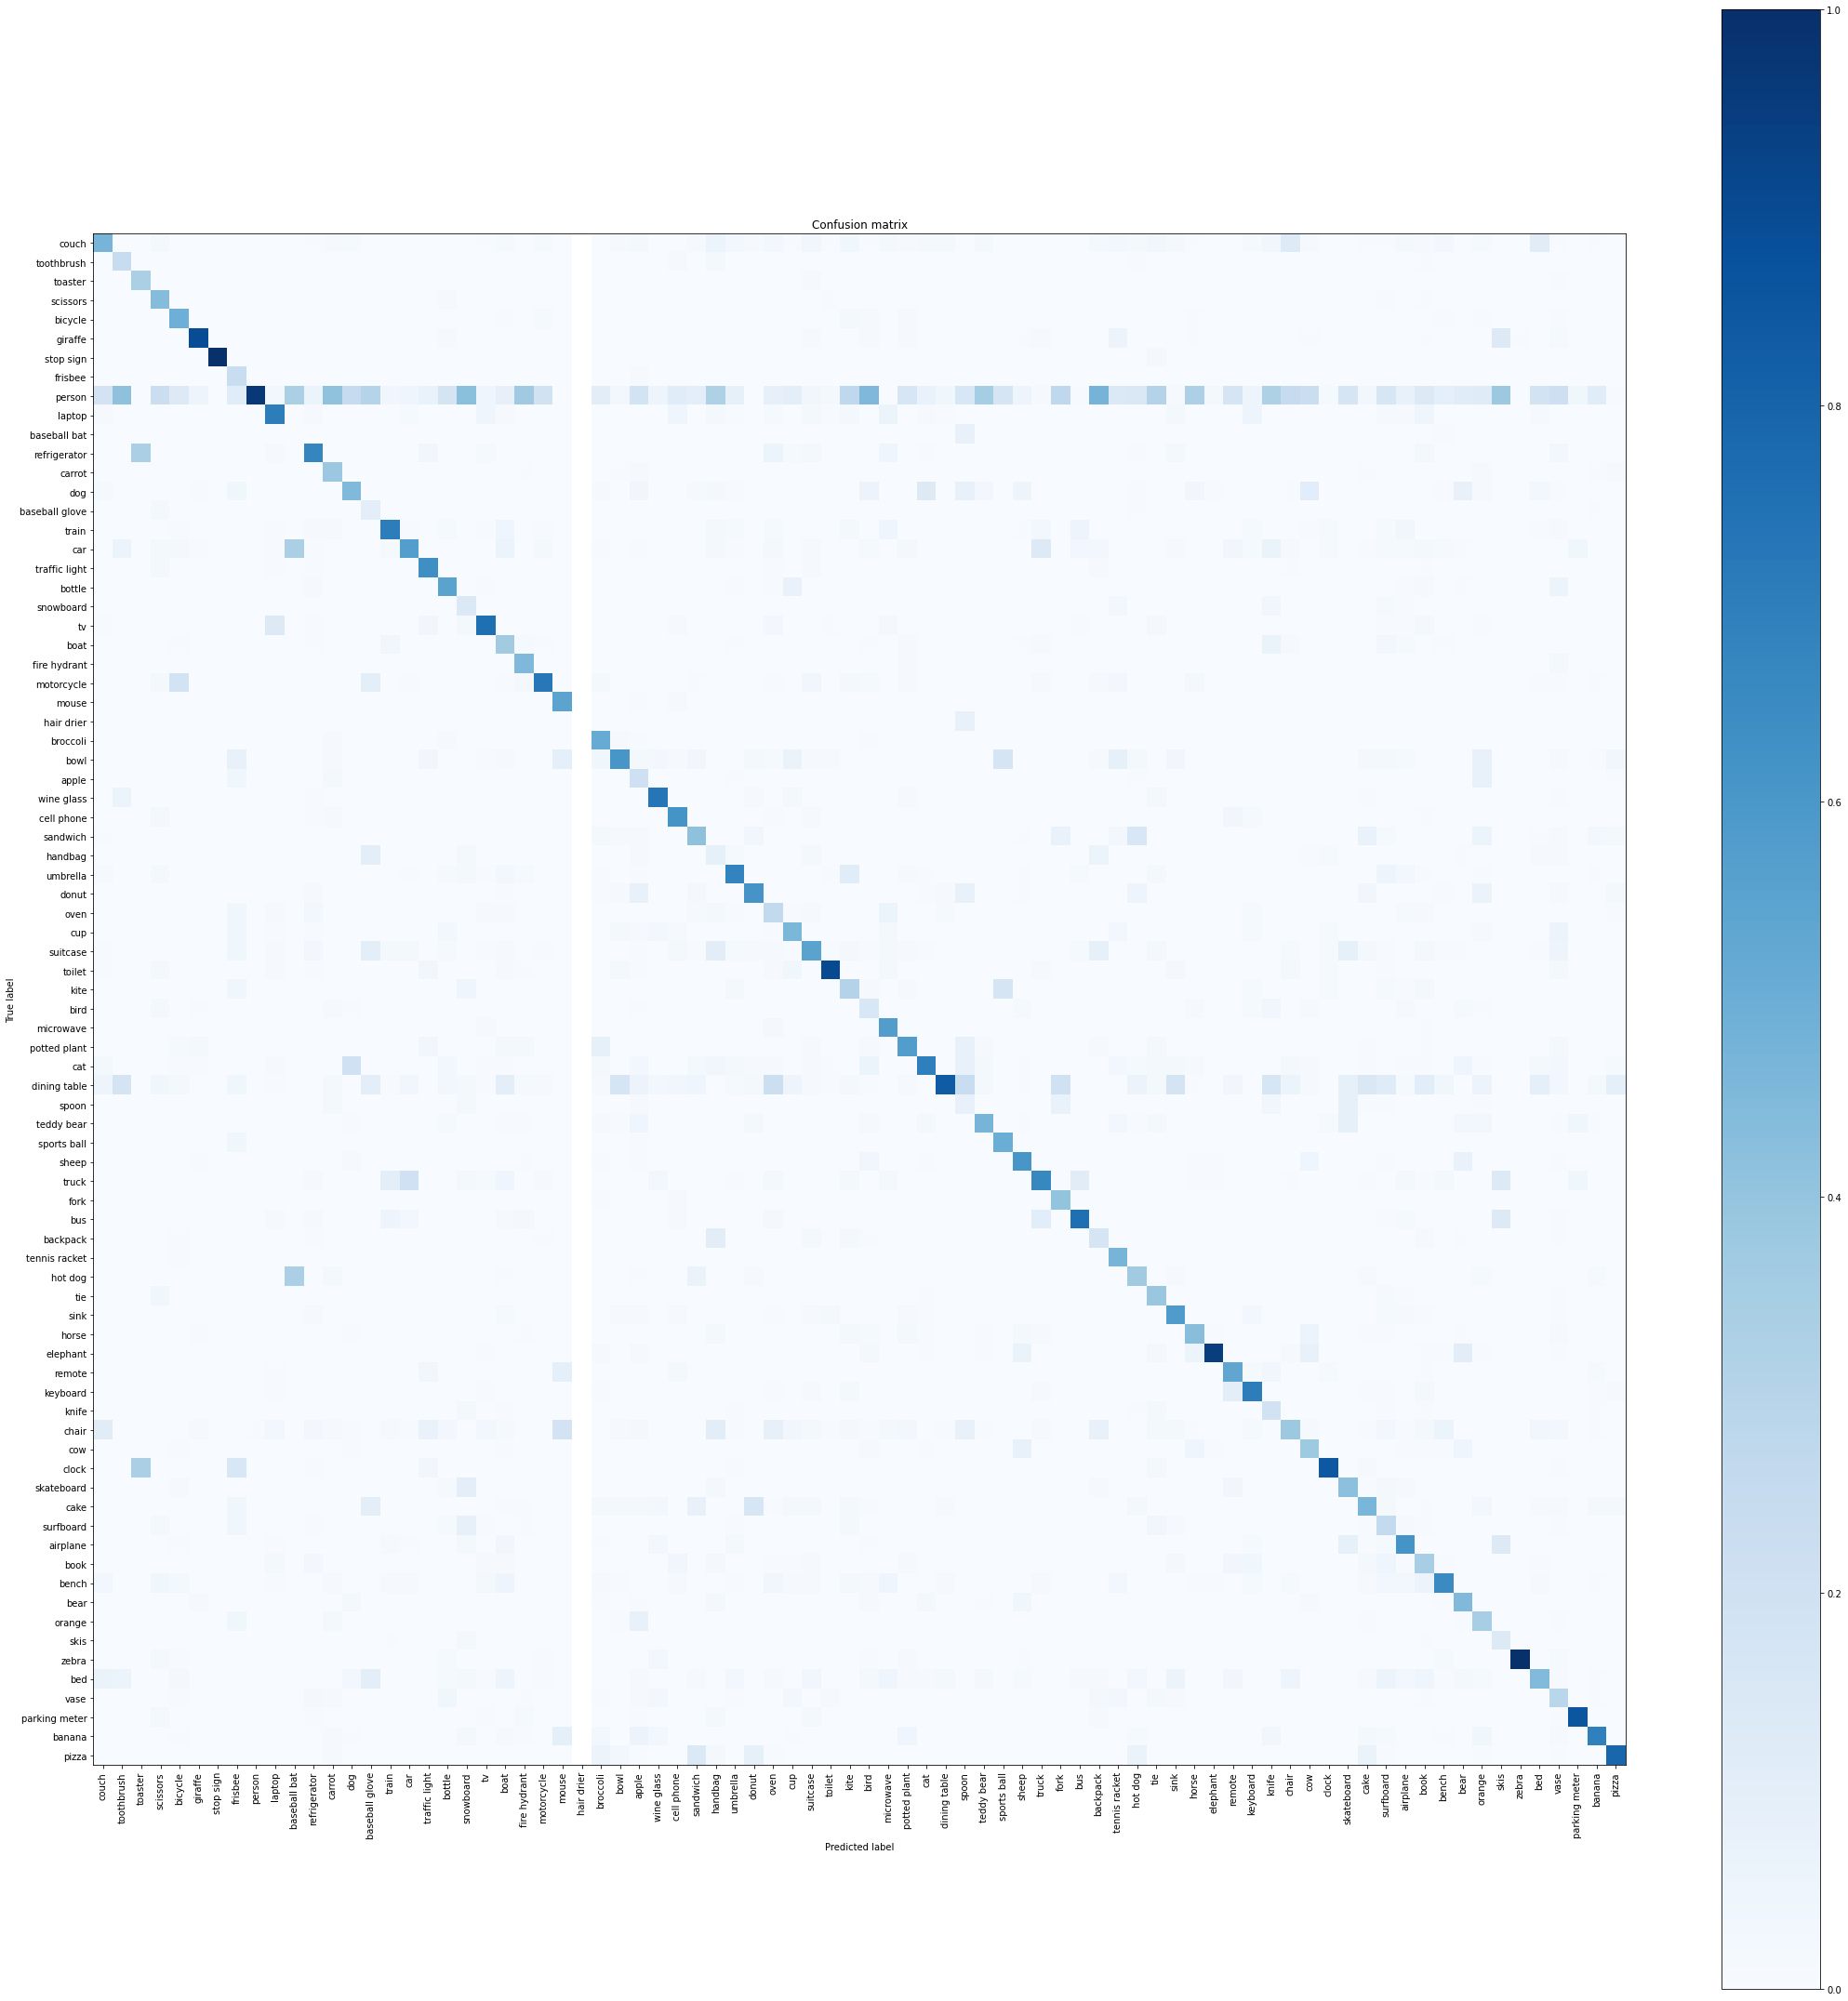

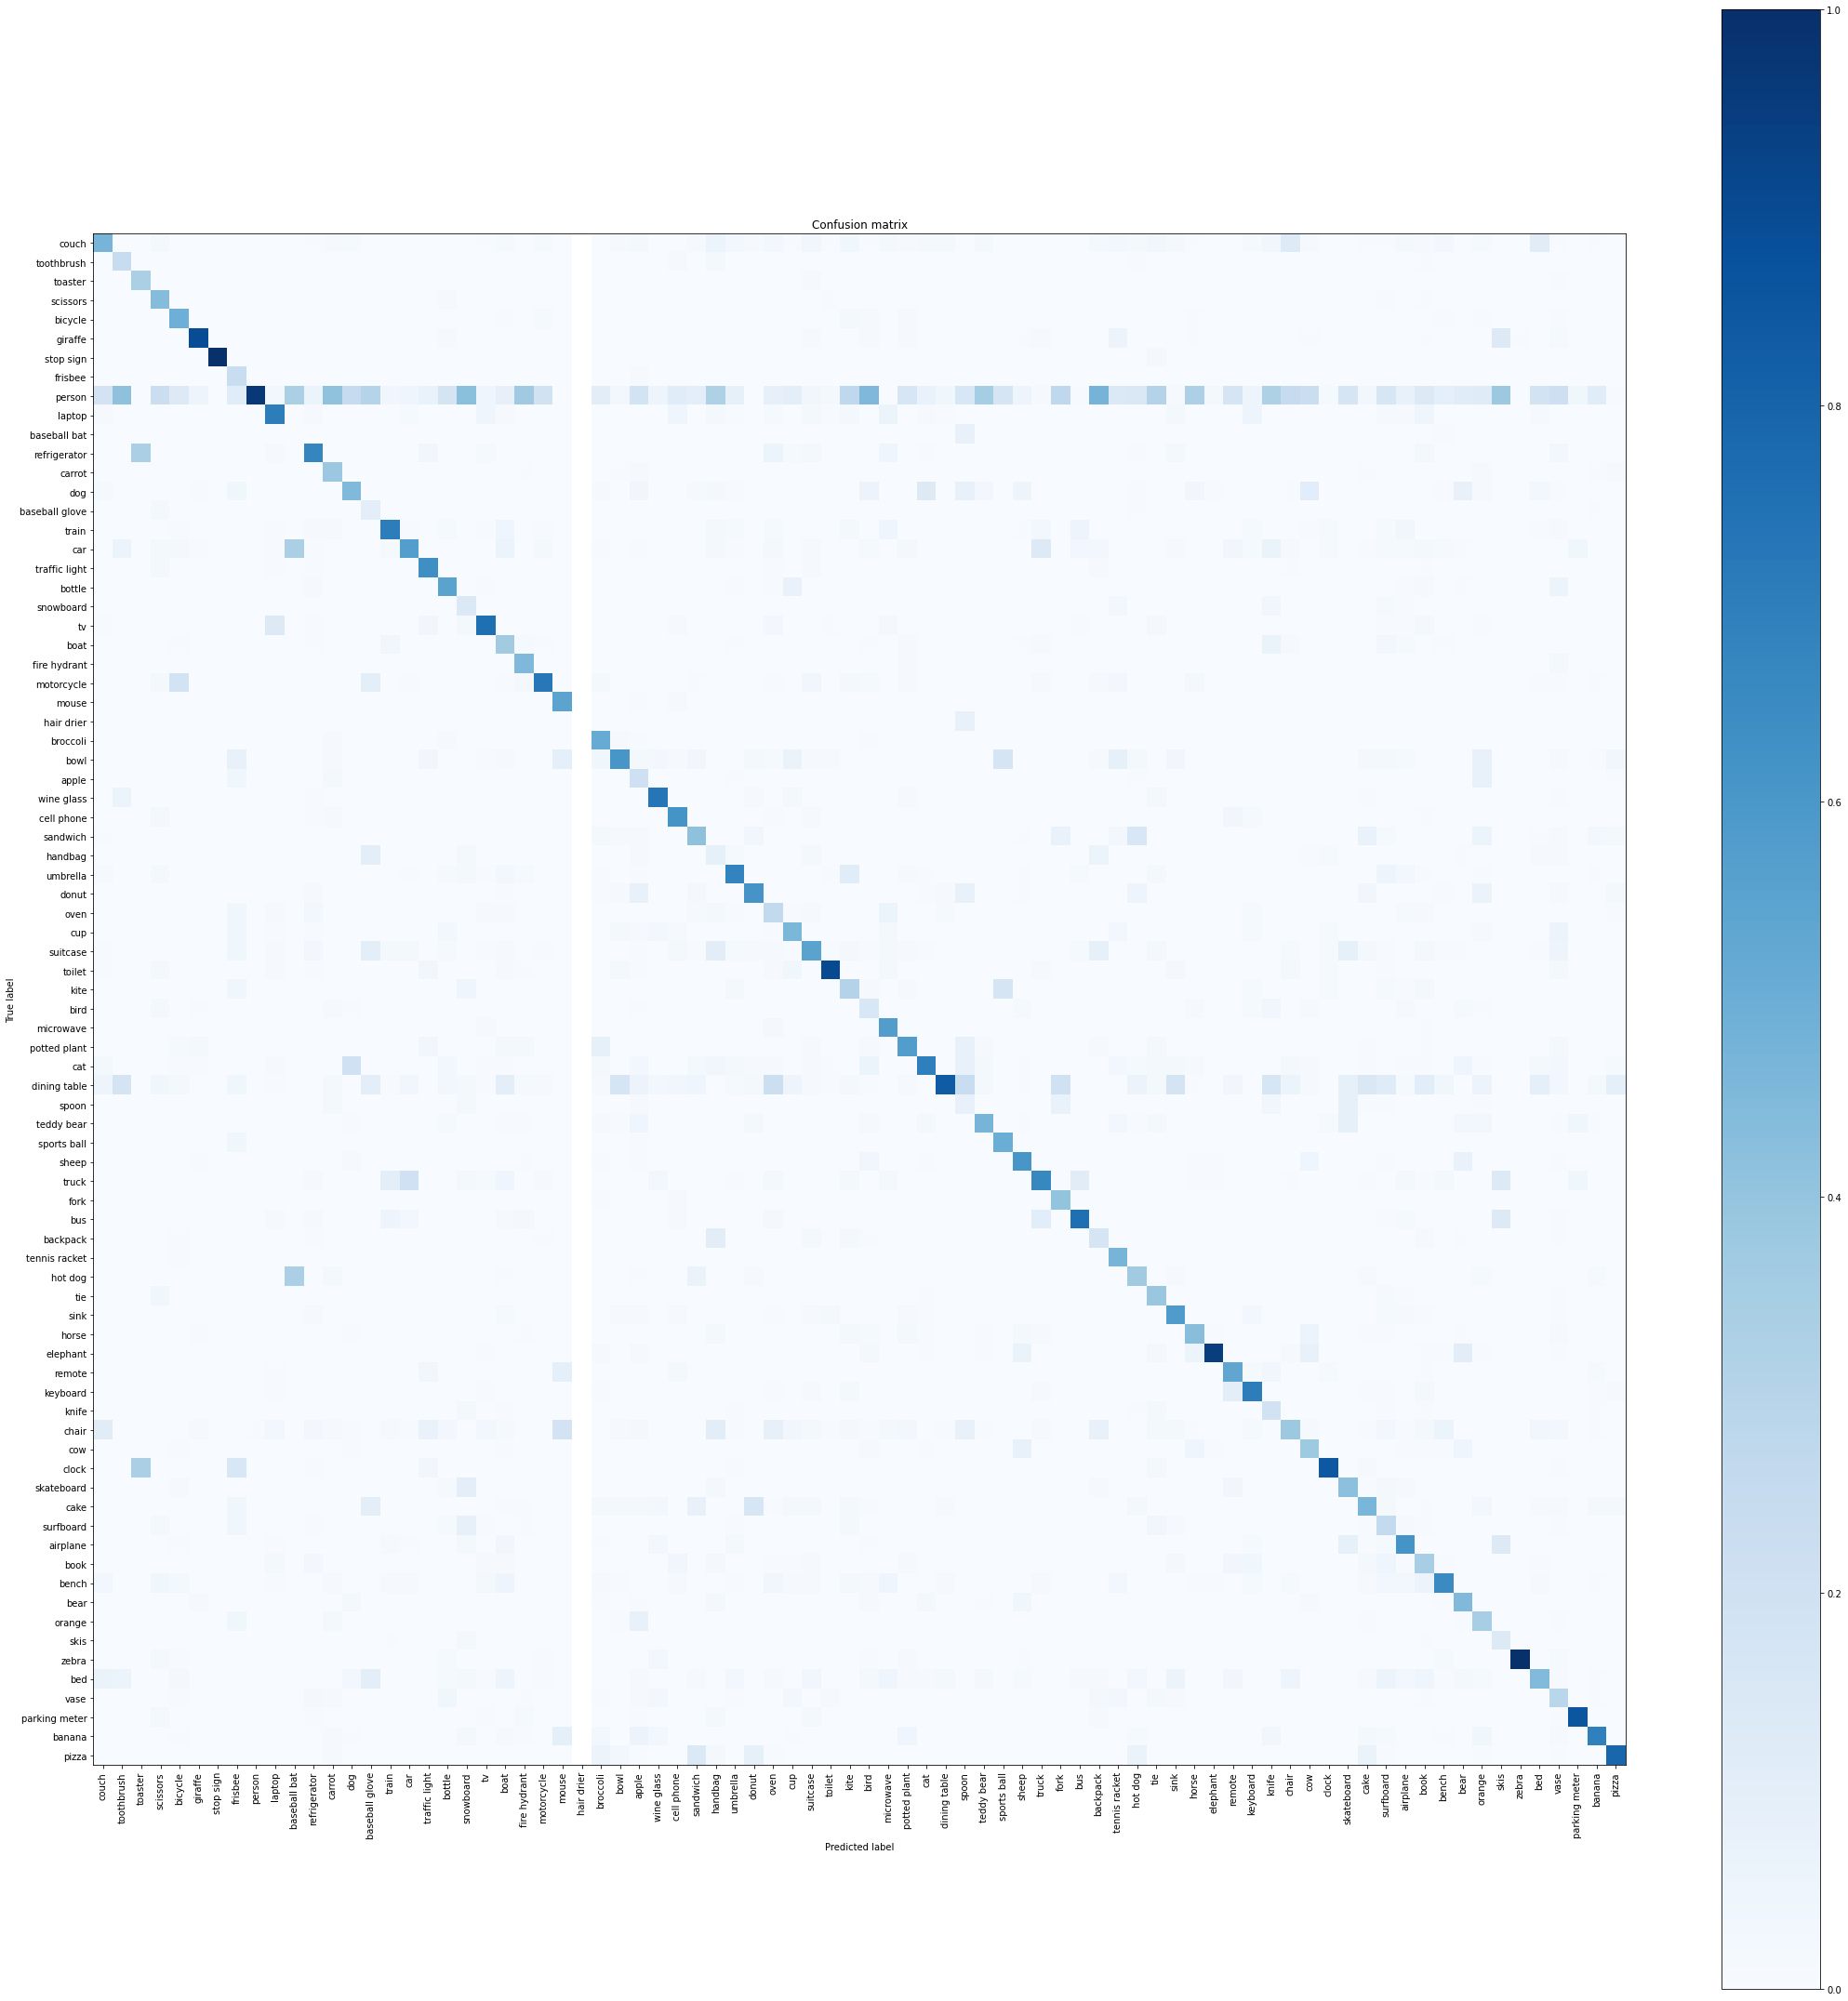

In [20]:
model = tf.keras.models.load_model('weights/resnet50/20220713-234715')

val_data = get_validation_data(coco_labels)
val_data = val_data.batch(32)
val_data = val_data.prefetch(32)

y = []
yhat = []

for batch in val_data:
    y.append([np.argmax(b) for b in batch[1]])
    yhat.append([np.argmax(b) for b in model.predict(batch[0])])

print(y[100])
print(yhat[100])

y = [x for xs in y for x in xs]
yhat = [x for xs in yhat for x in xs]

cm = np.array(tf.math.confusion_matrix(np.array(y), np.array(yhat)))
cm = cm / cm.astype(np.float).sum(axis=0)
print(cm)

plot_confusion_matrix(cm, coco_labels, "logs/resnet50/confusionmatrix1.jpg")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


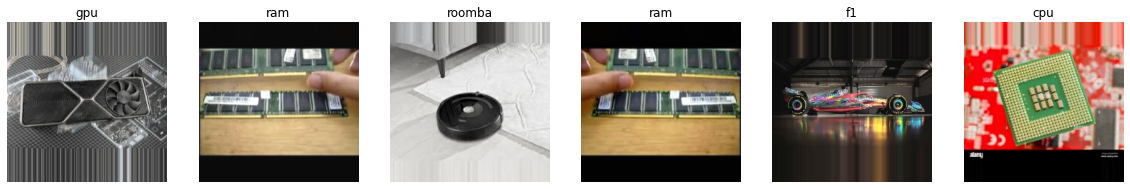

In [23]:
dataset = get_training_dataset(coco_labels_transfer, 900, False, True)
dataset = dataset.as_numpy_iterator()

plt.pyplot.figure(figsize=(20,20))
for i in range(6):
    ax = plt.pyplot.subplot(1,6,i+1)
    datatuple = next(dataset)
    plt.pyplot.imshow(datatuple[0])
    label = datatuple[1]
    label = np.where(label == 1)[0][0]
    plt.pyplot.title(coco_labels_transfer[label])
    plt.pyplot.axis("off")

In [24]:
BATCH_SIZE_T = 32
FROM_LOGITS_T = False
LEARNING_RATE_T = 0.001
INFO_T = "-"

CONFIG_STRING_T = "batch_size: {0} | last_dense: {1} | softmax: {2} | from_logits: {3} | lr: {4} | info: {5}"

METRICS_T = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [25]:
model = tf.keras.models.load_model('weights/resnet50/20220806-003011')
model.summary()

for layer in model.layers:
    layer.trainable = False

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 80)                163920    
                                                                 
Total params: 23,728,720
Trainable params: 23,683,280
Non-trainable params: 45,440
_________________________________________________________________


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_1 (Dense)             (None, 86)                176214    
                                                                 
Total params: 23,741,014
Trainable params: 176,214
Non-trainable params: 23,564,800
_________________________________________________________________


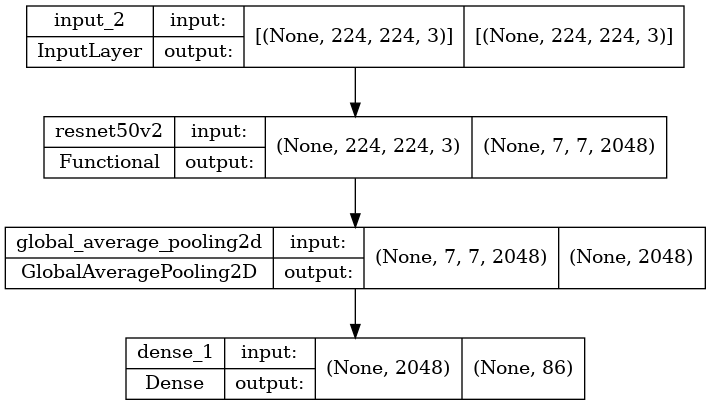

In [26]:


new_fc = Dense(len(coco_labels_transfer), activation='softmax')(model.layers[-2].output)
model2 = Model(inputs=model.input, outputs=new_fc)
model2.summary()
opt2 = Adam(learning_rate=LEARNING_RATE_T)
model2.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=FROM_LOGITS_T), optimizer=opt2, metrics=METRICS_T)

#model2.layers[-1].set_weights(old_layer_weights)
tf.keras.utils.plot_model(model2, to_file="logs/resnet50/model_transfer.png", show_shapes=True, expand_nested=False)

In [27]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir logs/resnet50

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = 'logs/resnet50/{0}_transfer'.format(current_time)
weight_dir = 'weights/resnet50/{0}_transfer'.format(current_time)

summary_writer = tf.summary.create_file_writer(log_dir)
summary_writer.set_as_default()
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, update_freq=100)
weight_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=weight_dir,
    save_weights_only=False,
    monitor='val_precision',
    mode='max',
    save_best_only=True)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 5564), started 11:17:46 ago. (Use '!kill 5564' to kill it.)

In [29]:





val_data2 = get_validation_data(coco_labels_transfer, True, True)
val_data2 = val_data2.batch(32)
val_data2 = val_data2.prefetch(32)

train_data = get_training_dataset(coco_labels_transfer, 2**18, True, True)
train_data = train_data.batch(32)
train_data = train_data.prefetch(32)

def train_transfer():
    print("Starting training...")

    #loss = siamese_model.fit(train_data, batch_size=32, epochs=20, validation_data=val_data, callbacks=[tensorboard_callback])
    hist_train = model2.fit(train_data, batch_size=BATCH_SIZE, validation_data=val_data2, callbacks=[tensorboard_callback, weight_callback], epochs=10)

train_transfer()

Starting training...
Epoch 1/10
8295/8295 [==============================] - 547s 66ms/step - loss: 0.5351 - tp: 208326.0000 - fp: 12459.0000 - tn: 22548384.0000 - fn: 57094.0000 - accuracy: 0.8615 - precision: 0.9436 - recall: 0.7849 - auc: 0.9949 - prc: 0.9305 - val_loss: 9.2160 - val_tp: 848.0000 - val_fp: 10802.0000 - val_tn: 1350643.0000 - val_fn: 15169.0000 - val_accuracy: 0.0625 - val_precision: 0.0728 - val_recall: 0.0529 - val_auc: 0.6004 - val_prc: 0.0330
Epoch 2/10
8295/8295 [==============================] - 549s 66ms/step - loss: 0.3212 - tp: 232810.0000 - fp: 12873.0000 - tn: 22548062.0000 - fn: 32610.0000 - accuracy: 0.9073 - precision: 0.9476 - recall: 0.8771 - auc: 0.9964 - prc: 0.9653 - val_loss: 6.3145 - val_tp: 2531.0000 - val_fp: 9832.0000 - val_tn: 1351613.0000 - val_fn: 13486.0000 - val_accuracy: 0.1767 - val_precision: 0.2047 - val_recall: 0.1580 - val_auc: 0.7152 - val_prc: 0.1222
Epoch 3/10
8295/8295 [==============================] - 551s 66ms/step - loss: 0.

In [155]:
model2.save('weights/resnet50/final_model.h5')

[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
[8, 8, 8, 8, 21, 62, 66, 39, 63, 13, 8, 8, 8, 32, 40, 32, 13, 8, 8, 8, 8, 62, 8, 8, 8, 75, 13, 57, 8, 8, 0, 8]
[[0.3376     0.         0.         ... 0.         0.         0.        ]
 [0.0016     0.17647059 0.         ... 0.         0.         0.        ]
 [0.         0.         0.5        ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.5        0.         0.        ]
 [0.         0.         0.         ... 0.         0.5        0.        ]
 [0.         0.         0.         ... 0.         0.         0.66666667]]


/tmp/ipykernel_4976/2268544240.py:21: RuntimeWarning: invalid value encountered in true_divide
  cm = cm / cm.astype(np.float64).sum(axis=0)


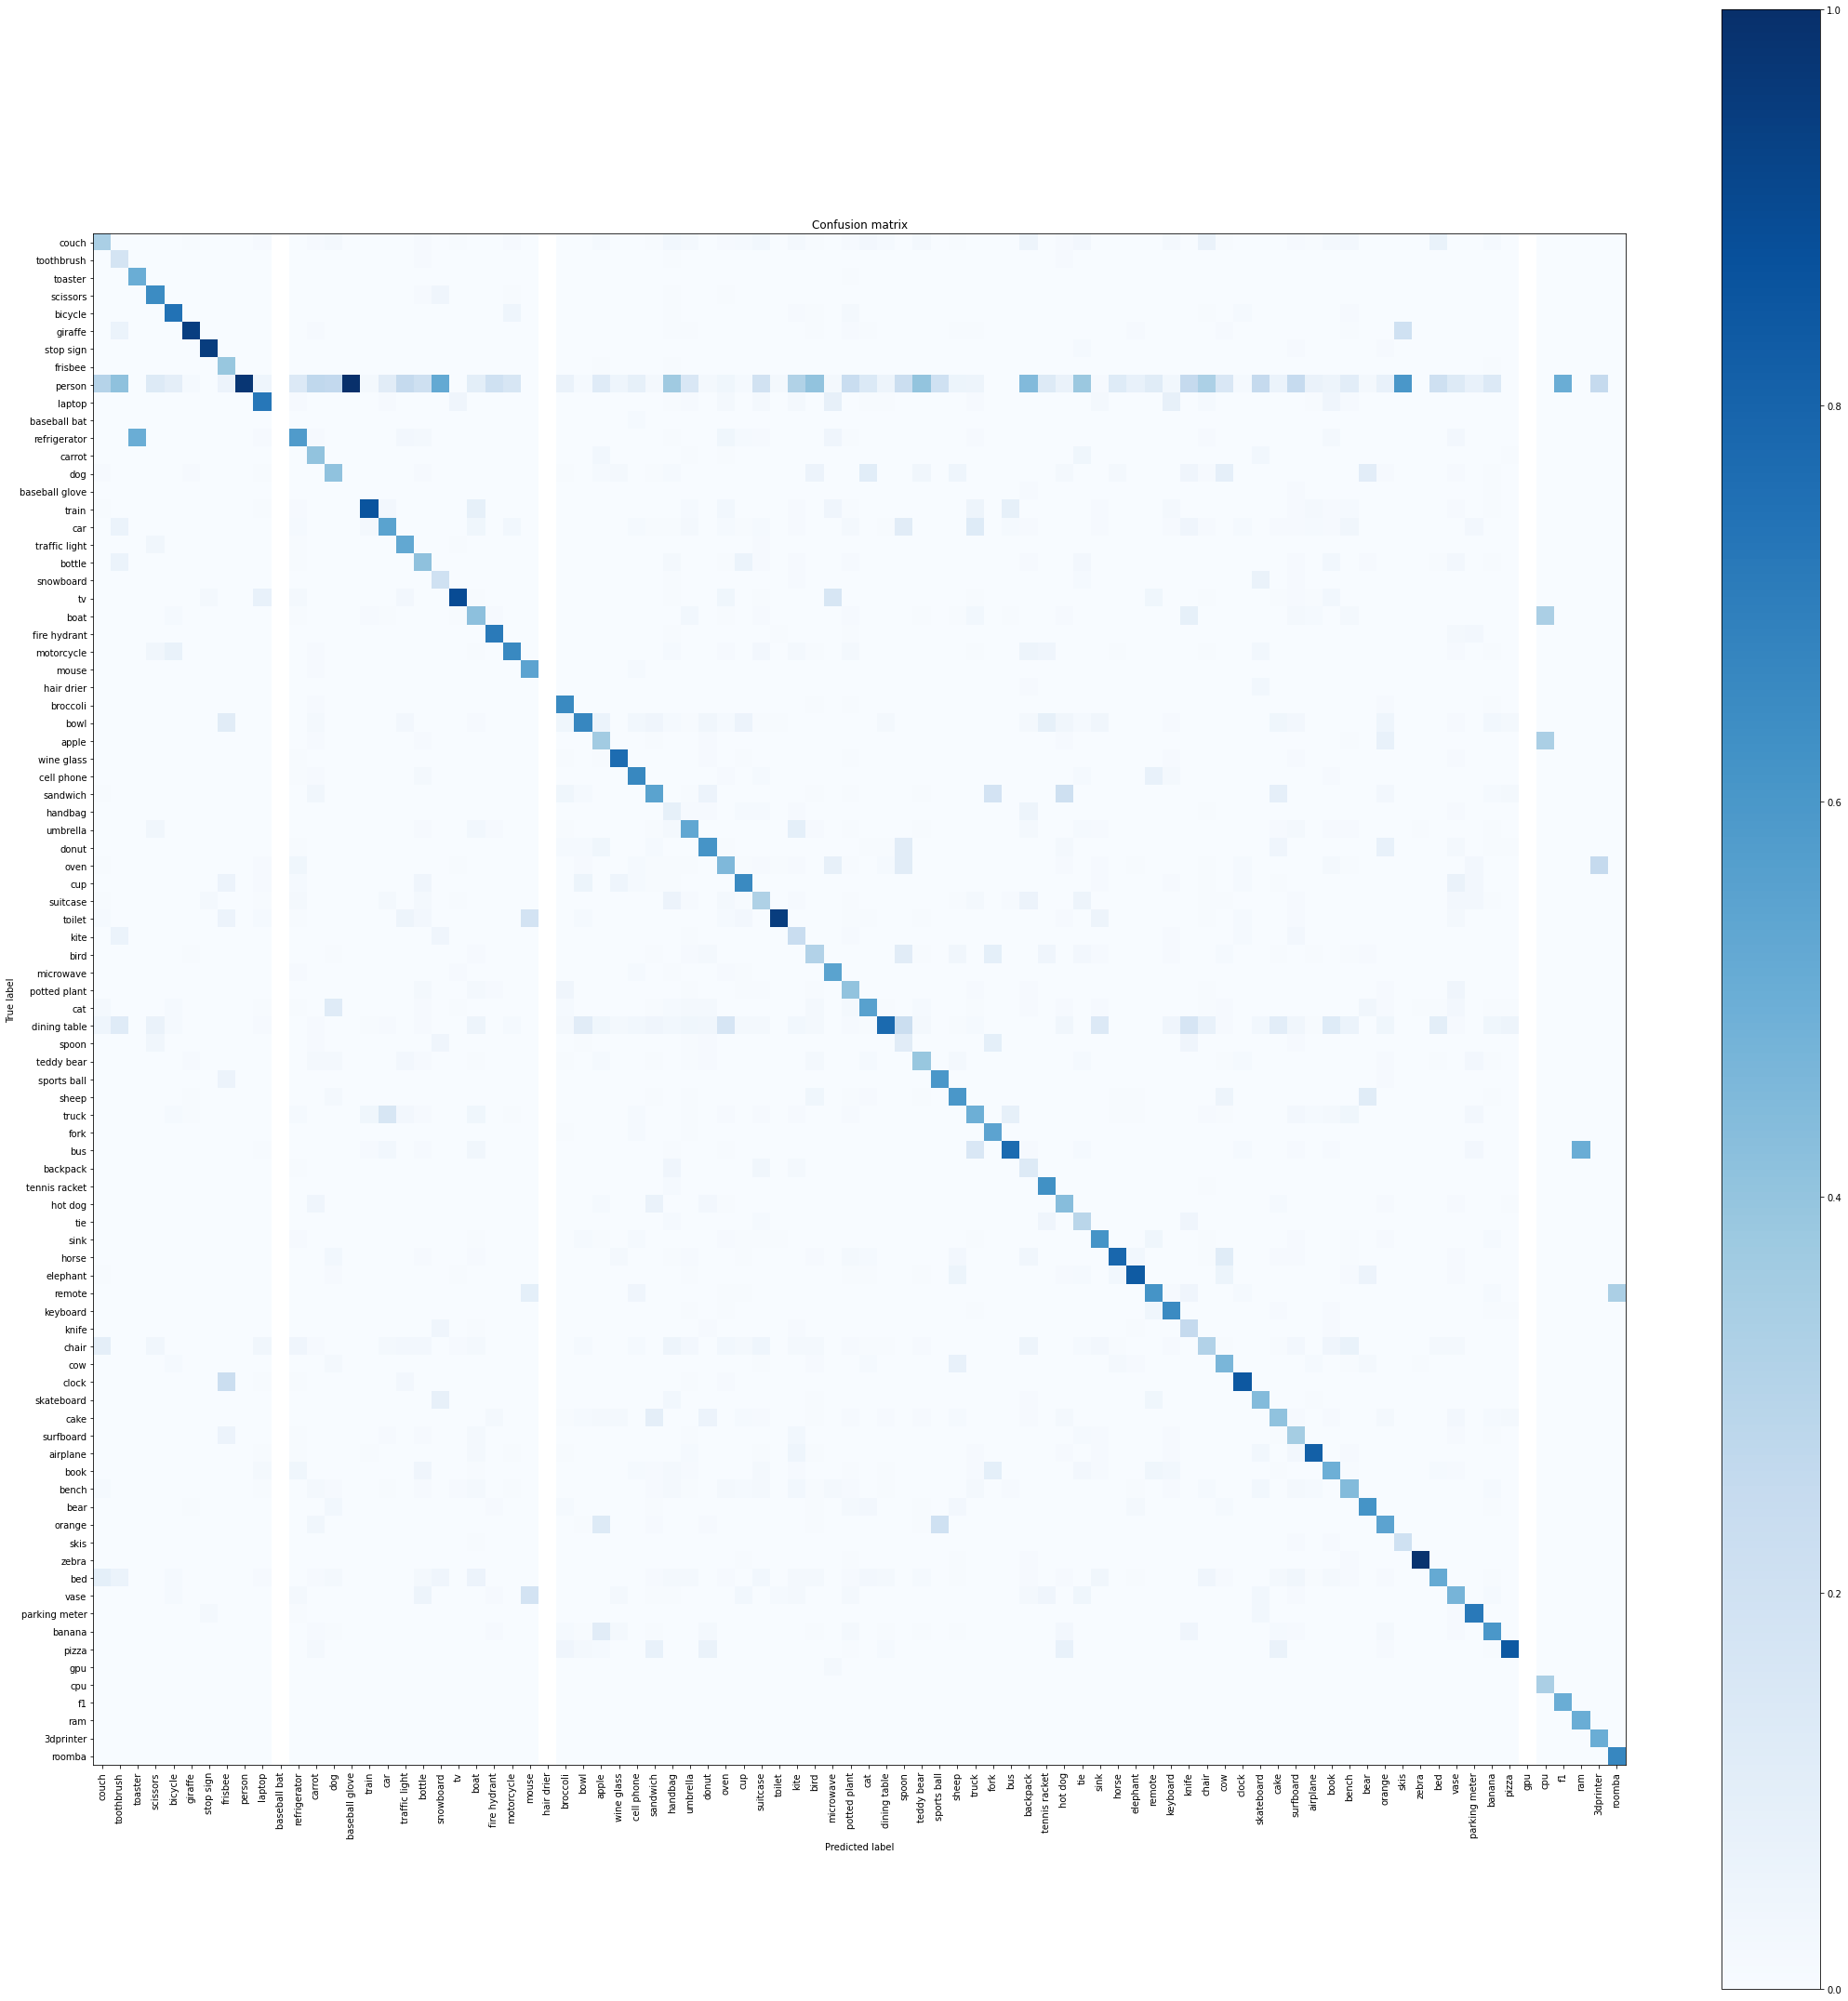

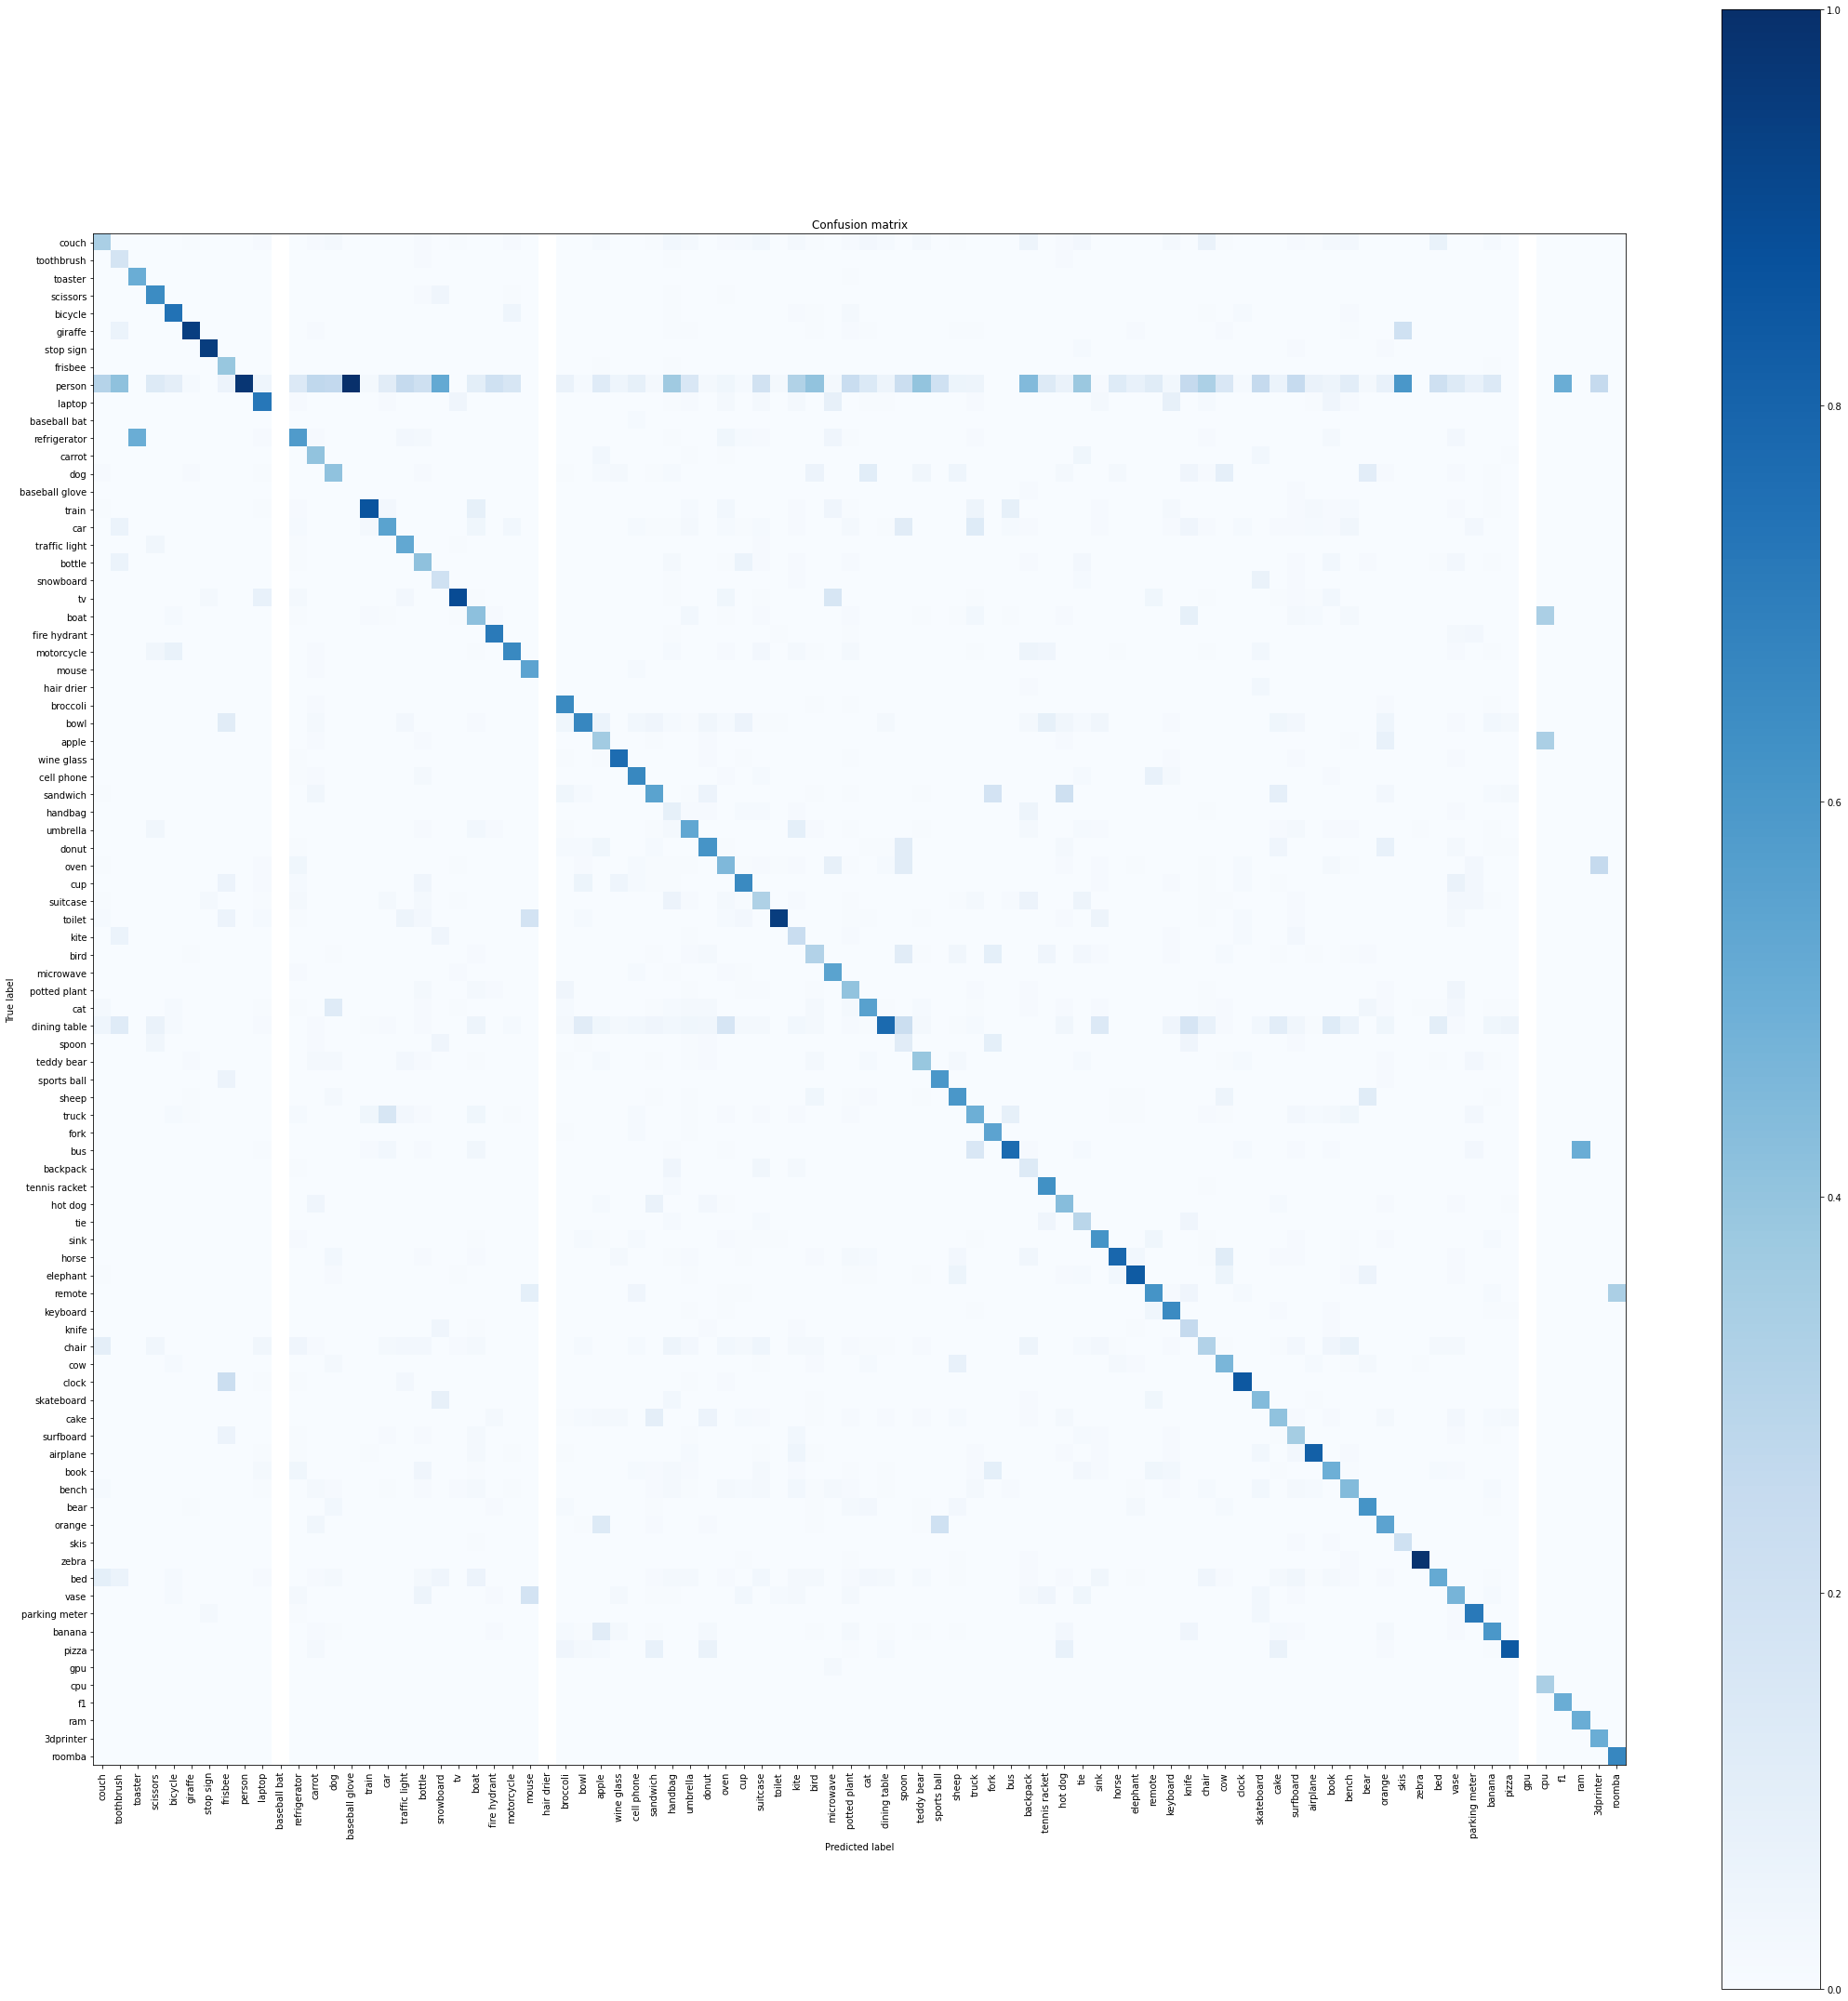

In [32]:
model2 = tf.keras.models.load_model('weights/resnet50/final_model.h5')

val_data = get_validation_data(coco_labels_transfer, True, True)
val_data = val_data.batch(32)
val_data = val_data.prefetch(32)

y = []
yhat = []

for batch in val_data:
    y.append([np.argmax(b) for b in batch[1]])
    yhat.append([np.argmax(b) for b in model2.predict(batch[0])])

print(y[100])
print(yhat[100])

y = [x for xs in y for x in xs]
yhat = [x for xs in yhat for x in xs]

cm = np.array(tf.math.confusion_matrix(np.array(y), np.array(yhat)))
cm = cm / cm.astype(np.float64).sum(axis=0)
print(cm)

plot_confusion_matrix(cm, coco_labels_transfer, "logs/resnet50/confusionmatrix-transferred.jpg")